# IMPORTING NECESSARY LIBRARIES

In [1]:
import sys
import cv2
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.metrics import structural_similarity as ssim
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# DATA PREPROCESSING

In [2]:
import os
import cv2

# preparing degraded images using quality distortions

def degrade_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        rows, cols, channels = img.shape
        new_rows = int(rows / factor)
        new_cols = int(cols / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_cols, new_rows), interpolation = cv2.INTER_LINEAR)
        #bilinear interpolation
        
        # resize the image - up
        img = cv2.resize(img, (cols, rows), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [3]:
degrade_images('source/',2)

Saving coastguard.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving lenna.bmp
Saving pepper.bmp
Saving t1.bmp
Saving t10.bmp
Saving t11.bmp
Saving t12.bmp
Saving t13.bmp
Saving t14.bmp
Saving t15.bmp
Saving t16.bmp
Saving t17.bmp
Saving t18.bmp
Saving t19.bmp
Saving t2.bmp
Saving t20.bmp
Saving t21.bmp
Saving t22.bmp
Saving t23.bmp
Saving t24.bmp
Saving t25.bmp
Saving t26.bmp
Saving t27.bmp
Saving t28.bmp
Saving t29.bmp
Saving t3.bmp
Saving t30.bmp
Saving t31.bmp
Saving t32.bmp
Saving t33.bmp
Saving t34.bmp
Saving t35.bmp
Saving t36.bmp
Saving t37.bmp
Saving t38.bmp
Saving t39.bmp
Saving t4.bmp
Saving t40.bmp
Saving t42.bmp
Saving t43.bmp
Saving t44.bmp
Saving t45.bmp
Saving t46.bmp
Saving t47.bmp
Saving t48.bmp
Saving t49.bmp
Saving t5.bmp
Saving t50.bmp
Saving t51.bmp
Saving t52.bmp
Saving t53.bmp
Saving t54.bmp
Saving t55.bmp
Saving t56.bmp
Saving t57.bmp
Saving t58.bmp
Saving t59.bmp
Saving t6.bmp
Saving t60.bmp
Saving t61.bmp
Saving t62.bmp
Saving t63.bmp
Saving t64.bmp
Saving t65.

In [4]:
Path="dataset/dataset_updated/training_set/painting/"

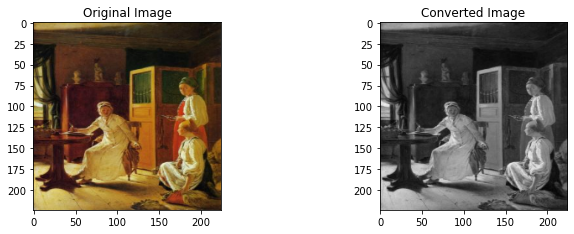

In [5]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
image = cv2.imread(Path+"1310.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
plt.title("Original Image")
plt.imshow(image)
image.shape

plt.subplot(5,5,1+1)
img = cv2.imread(Path+"1310.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Converted Image")
plt.imshow(img)

In [6]:
HEIGHT=224
WIDTH=224
ImagePath="dataset/dataset_updated/training_set/painting/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for file in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
            img = img.astype(np.float32)
            
            #Lab value --> L - lightness, a and b - color spectra green–red and blue–yellow.
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            
            #resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT))
            
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            img_ab = img_ab/128
            
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [7]:
X,Y = ExtractInput(ImagePath)

# Image Quality Metrics

In [8]:
# peak signal-to-noise ratio (PSNR)
def psnr(target,ref): #target image and refernce image
    
    #assume RGB image and convert all integer values to float
    target_data=target.astype(float)
    ref_data=ref.astype(float)
    
    diff=ref_data-target_data
    diff=diff.flatten('C') #flatten - so that computations can be done
    
    rmse=math.sqrt(np.mean(diff**2.))
    
    return 20*math.log10(255./rmse)

# mean squared error(MSE)
def mse(target,ref):
    # MSE between two images - sum of the squared difference between the two images
    err=np.sum((target.astype('float')-ref.astype('float'))**2)
    err=err/float(target.shape[0]*target.shape[1]) # divided by total number of pixels
    
    return err

# combine all three image quality metrics
def compare_images(target,ref):
    scores=[]
    scores.append(psnr(target,ref))
    scores.append(mse(target,ref))
    scores.append(ssim(target,ref,multichannel=True))# multichannel to handle 3 channel images RGB/BGR 
    
    return scores

# Testing Low Quality Images

In [9]:
#testing generated images using image quality metrics

for file in os.listdir('images/'):
    
    # open target and reference images
    target=cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculating scores
    scores=compare_images(target,ref)
    
     # printing all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))
        

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

flowers.bmp
PSNR: 27.454504805386147
MSE: 350.55093922651935
SSIM: 0.8697286286974628

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.933268417388899

lenna.bmp
PSNR: 31.47349297867539
MSE: 138.94800567626953
SSIM: 0.8460989200521499

pepper.bmp
PSNR: 29.88947161686106
MSE: 200.1033935546875
SSIM: 0.8357937568464359

t1.bmp
PSNR: 30.26306098161202
MSE: 183.6096562067374
SSIM: 0.8957837282335709

t10.bmp
PSNR: 21.238863752549296
MSE: 1466.6120209629871
SSIM: 0.7681151403814352

t11.bmp
PSNR: 24.59313993758269
MSE: 677.4661835748792
SSIM: 0.8335180797283744

t12.bmp
PSNR: 31.452156738555797
MSE: 139.63231608432847
SSIM: 0.8903201827280801

t13.bmp
PSNR: 33.29836565152635
MSE: 91.2777761180653
SSIM: 0.9186395751761453

t14.bmp
PSNR: 40.595411124622245
MSE: 17.008284162400845
SSIM: 0.9565051658263002

t15.bmp
PSNR: 31.744680634553003
MSE: 130.53697733952782
SSIM: 0.8990576926040181


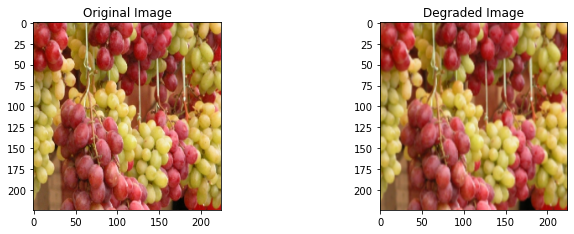

In [10]:
Path_1="source/"
Path_2="images/"

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
image = cv2.imread(Path_1+"tt26.bmp")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
plt.title("Original Image")
plt.imshow(image)
image.shape

plt.subplot(5,5,1+1)
img = cv2.imread(Path_2+"tt26.bmp")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.title("Degraded Image")
plt.imshow(img)

# Building the Models

In [11]:
# define the CNN model
def model():
    
    # define model type
    CNN = Sequential()
    
    #add model layers 
    #filters - no. of nodes in the layer
    CNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    CNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    CNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    CNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return CNN

In [12]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_ = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3), activation='relu',padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3), activation='relu',padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3), activation='relu',padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(concat_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [13]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [14]:
Model_Colourization.compile(optimizer="adam", loss='mean_squared_error')
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 4640        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
# training the CNN model

def GenerateInputs(X_, Y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        Y_input = Y_[i].reshape(1,224,224,2)
        yield (X_input,Y_input)
Model_Colourization.fit_generator(GenerateInputs(X, Y),epochs=4,verbose=1,steps_per_epoch=2)

Epoch 1/4
2/2 [==============================] - 15s 5s/step - loss: 0.1793
Epoch 2/4
2/2 [==============================] - 4s 2s/step - loss: 0.1539
Epoch 3/4
2/2 [==============================] - 3s 2s/step - loss: 0.1160
Epoch 4/4
2/2 [==============================] - 3s 2s/step - loss: 0.0617


In [16]:
# preprocess images

def modcrop(img,scale):
    #temp size
    tmpsz=img.shape
    sz=tmpsz[0:2]
    
    #ensures that dimension of our image are divisible by scale
    
    sz=sz-np.mod(sz,scale)    #np.mod returns the remainder bewtween our sz and scale
    
    img=img[0:sz[0],1:sz[1]]
    return img

#crop offs the bordersize from all sides of the image

def shave(image,border):
    img=image[border: -border,border:-border]
    return img

In [17]:
# prediction function

def predict(image_path):
    
    #load the CNN model with weights
    CNN = model()
    CNN.load_weights('3051crop_weight_200.h5')
     
    #load the degraded and reference images
    
    path,file=os.path.split(image_path)
    degraded=cv2.imread(image_path)
    ref=cv2.imread('source/{}'.format(file))
    
    #preprocess the image with modcrop
    
    ref=modcrop(ref,3)
    degraded=modcrop(degraded,3)
    
    #convert the image to YCrCb (3 channel image) - CNN trained on Y channel
    temp=cv2.cvtColor(degraded,cv2.COLOR_BGR2YCrCb) # Y is the brightness (luma), Cb is blue minus luma (B-Y) and Cr is red minus luma (R-Y).
    
    #create image slice and normalize to single dimension
    Y=np.zeros((1,temp.shape[0],temp.shape[1],1),dtype=float)
   
    #fill in the data; all values are normalized to between 0 and 1
    Y[0,:,:,0]=temp[:,:,0].astype(float)/255
    
   
    #perform high-quality with cnn
    pre = CNN.predict(Y,batch_size=1)
    
    
    pre*=255
    pre[pre[:]>255]=255
    pre[pre[:]<0] =0
    pre=pre.astype(np.uint8)
    
    temp=shave(temp,6)
    
    temp[:,:,0]=pre[0,:,:,0]
    
    #convert back to bgr
    output=cv2.cvtColor(temp,cv2.COLOR_YCrCb2BGR)
    
    #emove borderfrom reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    #image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref)) #degraded wrt ref
    scores.append(compare_images(output, ref)) #high-quality output wrt ref
    
    # return images and scores
    return ref, degraded, output, scores

Degraded Image: 
PSNR: 27.248686459559124
MSE: 367.56400047398984
SSIM: 0.8690622024599293

Reconstructed Image: 
PSNR: 29.66020048831105
MSE: 210.95098945372675
SSIM: 0.8989100264554274



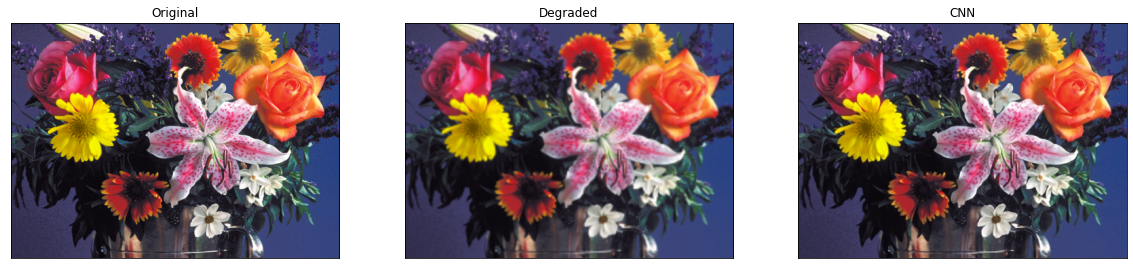

In [18]:
ref,degraded,output,scores=predict('images/flowers.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('CNN')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
for file in os.listdir('images'):
    
    # convert to high-quality
    ref, degraded, output, scores = predict('images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

In [22]:
TestImagePath="dataset/dataset_updated/training_set/painting/"

In [23]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped

In [30]:
ImagePath=TestImagePath+"0018.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

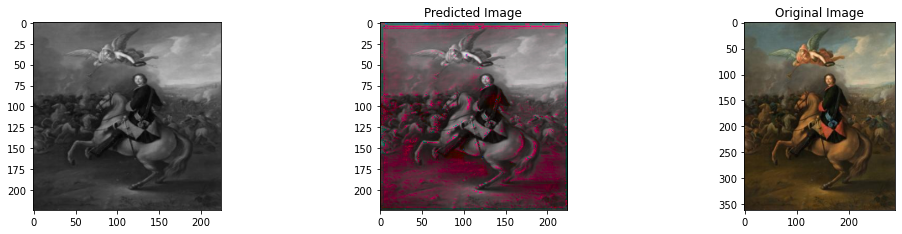

In [31]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"0018.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Original Image")
plt.imshow(img_1)